<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-04/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 04
## Author: Colin Scherer

### **Task 2: RNNs**

The dataset I have chosen this week is a database of youtube comments, along with their tones (positive, negative and neutral). My task will be classifying a given sentence into either positive, negative, or neutral tones. The link can be found here: https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset

In [138]:
import numpy as np
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/YoutubeCommentsDataSet.csv")

# Used for balancing the dataset
def load_dataset(dat, tar):
  vals, cts = np.unique(tar, return_counts=True)
  min_val = vals[np.argmin(cts)]
  min_ct = min(cts)
  new_dat = dat[tar == min_val]
  new_tar = tar[tar == min_val]
  for i, v in enumerate(vals):
    if v != min_val:
      indices = list(np.where(tar == v))[0]
      new_ind = np.random.choice(indices, min_ct)
      new_dat = np.append(new_dat, dat[new_ind], axis=0)
      new_tar = np.append(new_tar, tar[new_ind])
  return new_dat, new_tar

# Cleans text
def clean_text(text):
    text = str(text).lower() # Ensure no duplicate word embeddings due to capital letters
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove urls
    text = re.sub(r"@\w+", "", text)              # Remove mentions
    text = re.sub(r"[^a-z0-9' ]", "", text)       # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()      # Remove extra spaces
    return text

df["Cleaned"] = df["Comment"].apply(clean_text)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
print("Data counts initially:")
print(df.count(axis=0))
df.dropna(axis=0, inplace = True)
print("\n Data counts after dropped empty comments:")
print(df.count(axis=0))
df = df.drop_duplicates(subset = "Cleaned")
print("\n Data counts after dropped duplicates:")
print(df.count(axis=0))

Data counts initially:
Comment      18364
Sentiment    18408
Cleaned      18408
dtype: int64

 Data counts after dropped empty comments:
Comment      18364
Sentiment    18364
Cleaned      18364
dtype: int64

 Data counts after dropped duplicates:
Comment      17635
Sentiment    17635
Cleaned      17635
dtype: int64


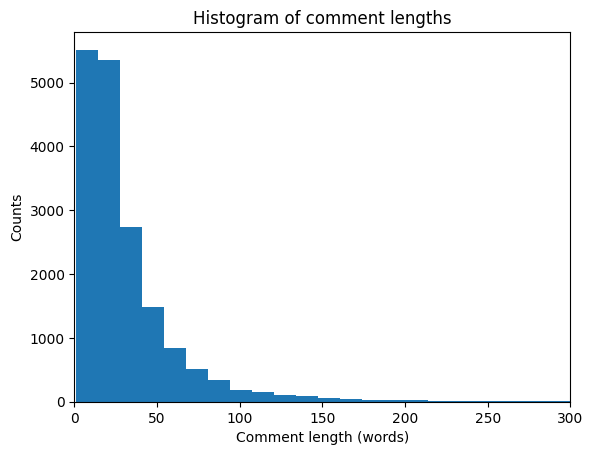

Average length: 33.21
Median length: 21.00
Percent over length 100: 0.0438


In [140]:
def split(s):
  return s.split(' ')

df['Lengths'] = df["Cleaned"].apply(split)
df['Lengths'] = df['Lengths'].apply(len)

plt.hist(df['Lengths'],bins=100)
plt.xlim(0,300)
plt.ylabel("Counts")
plt.xlabel("Comment length (words)")
plt.title("Histogram of comment lengths")
plt.show()

print("Average length: {:.2f}".format(np.mean(df['Lengths'])))
print("Median length: {:.2f}".format(np.median(df['Lengths'])))
print("Percent over length 100: {:.4f}".format(df[df['Lengths'] > 100].shape[0]/df.shape[0]))

In [141]:
print(np.unique(df['Sentiment'], return_counts = True))

(array(['negative', 'neutral', 'positive'], dtype=object), array([ 2316,  4320, 10999]))


From above, the sentiments are highly unbalanced, with positive comments making up the majority. Because of this, I will stratify my dataset by sentiment. The histogram also demonstrates that the percent of comments over length 100 is less than 5%, so I can safely use that as my maximum comment length, so that there isn't too much padding.

In [142]:
from sklearn.model_selection import train_test_split

comments = df['Cleaned']
labels = np.array(df['Sentiment'])
labels[labels == 'positive'] = 2
labels[labels == 'neutral'] = 1
labels[labels == 'negative'] = 0
labels = np.array(labels, dtype=np.uint8)
comments = np.array(comments)

comments = [comment.split() for comment in comments]
vocab = set([word for comment in comments for word in comment])
vocab = {word: idx+1 for idx, word in enumerate(vocab)} # Create word encodings with dictionary
vocab['<0>'] = 0 # Add padding value to dictionary
max_len = 100 # Set maximumm comment length equal to 100. From the above distribution, this won't truncate many comments.

padded_comments = []
for comment in comments:
    if len(comment) > max_len:
        padded_comments.append(comment[:max_len])
    else:
        padded_comments.append(comment + ['<0>'] * (max_len - len(comment)))

encoded_comments = [[vocab[word] for word in comment] for comment in padded_comments]

# Split dataset into 3:1:1 ratio of train:val:test
X_train, X_test, y_train, y_test = train_test_split(encoded_comments, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Ensure equal distribution of comment sentiments
X_train, y_train = load_dataset(np.array(X_train), y_train)
X_val, y_val = load_dataset(np.array(X_val), y_val)
X_test, y_test = load_dataset(np.array(X_test), y_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype = torch.long)
X_test = torch.tensor(X_test, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)


In [143]:
from torch import nn

# Implementation for basic RNN
class myRNN(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super(myRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(input_dim, embed_dim, padding_idx=0)
    self.drop = nn.Dropout(0.3)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first = True)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)

  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, res = self.rnn(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)


# Implementation for LSTM
class myLSTM(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(input_dim, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
    self.drop = nn.Dropout(0.3)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)

  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, (res, _) = self.lstm(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)


# Implementation for GRU
class myGRU(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(input_dim, embed_dim)
    self.gru = nn.GRU(embed_dim, hidden_dim, batch_first = True)
    self.drop = nn.Dropout(0.3)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)


  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, res = self.gru(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)



All my models have the same layer structure, besides the main RNN layer. For the activation functions, I am just using the default $\tanh$ -- although I experimented a bit with ReLu, I didn't notice much of a performance difference. For the output layer, I am using softmax so that the probabilities of positive, neutral, and negative tones add up to 1. Since this is a sentiment detection problem, I am also using a word embedding layer, which should hopefully capture richer semantic meanings between words. I also have 2 dropout layers with $p=0.3$ -- one after the embedding layer, and one after the RNN layers. These should help reduce overfitting with both the embedding weights and the RNN weights.

In [144]:
from torch import optim
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split

def train(model, loss_fn, optimizer, X, y, X_val, y_val, X_test, epochs, val_epoch, name):
  val_losses = []
  train_losses = []
  for e in range(epochs):
    model.train()
    e_loss = []
    for batch in range(X.shape[0]//batch_size):
      optimizer.zero_grad()
      pred = model(X[batch*batch_size:(batch+1)*batch_size])
      loss = loss_fn(pred, y[batch*batch_size:(batch+1)*batch_size])
      e_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    train_losses.append(sum(e_loss)/len(e_loss))
    print("Epoch {}: {:.5f}".format(e, train_losses[-1]))

    if e % val_epoch == 0:
      model.eval()
      with torch.no_grad():
        pred = model(X_val)
        loss = loss_fn(pred, y_val)
        print("Validation loss: {:.5f}".format(loss.item()))
        print("Validation accuracy: {:.4f}".format(accuracy_score(y_val, np.argmax(pred, axis=1))))
        val_losses.append(loss.item())
        if len(val_losses) > 12 and np.min(val_losses[-7::-1]) <= np.min(val_losses[-6:-1]):
          break
    print()
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_losses': train_losses,
      'valid_losses': val_losses}, "/content/drive/MyDrive/Colab Notebooks/{}.pt".format(name))

  test_pred = None
  model.eval()
  with torch.no_grad():
    test_pred = model(X_test)
  return train_losses, val_losses, test_pred


The metric I will use to evaluate my model is just accuracy score, although I will also report f1, recall, and precision scores. During training, validation is performed every 5 epochs, and training is stopped early if the previous 5 validation losses don't reach a minimum that was reached in the 6 validation losses before. This choice may seem arbitrary, but it required some fine-tuning: since the losses from GRU especially can be very volatile, using average losses over some epochs could stop the model well before it was ready. During training, validation accuracy is also reported, which was a good predictor for how accurate my models would be on the test set.


Simple RNN Test metrics:
f1 score: 0.35131
recall score: 0.35925
precision score: 0.36096
Overall accuracy: 35.93%

LSTM Test metrics:
f1 score: 0.45629
recall score: 0.47444
precision score: 0.47575
Overall accuracy: 47.44%

GRU Test metrics:
f1 score: 0.52350
recall score: 0.52916
precision score: 0.52776
Overall accuracy: 52.92%


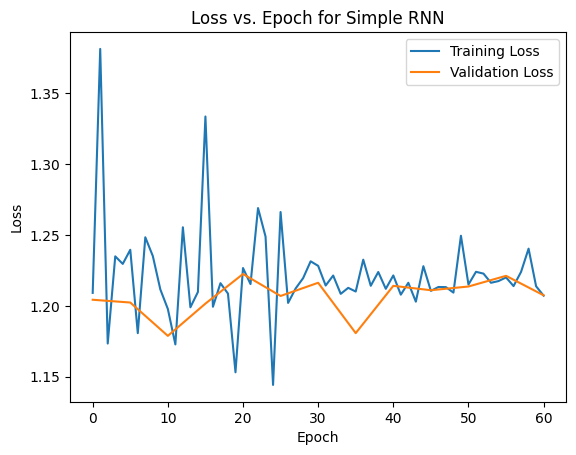

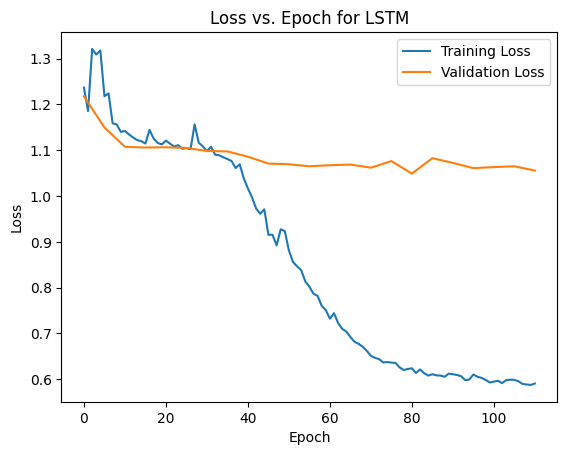

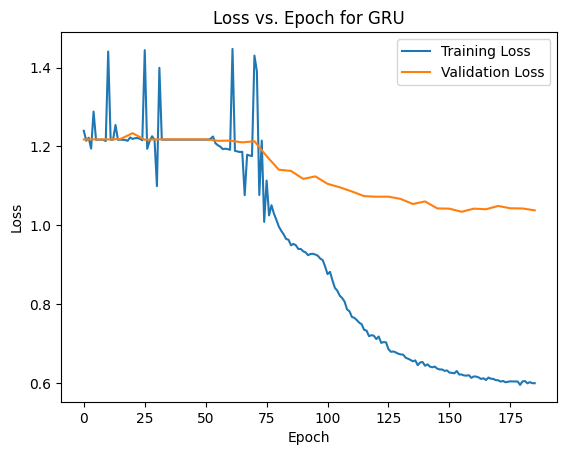

In [150]:
from torch import optim
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score


# Hyperparameters
epochs = 300
batch_size = 32
val_epoch = 5
learning_rate = 0.001
# SET TO FALSE IF TRAINING FROM SCRATCH
load_pretrained = True
train_l_rnn, val_l_rnn, test_pred_rnn, train_l_lstm, val_l_lstm, test_pred_lstm, train_l_gru, val_l_gru, test_pred_gru = None, None, None, None, None, None, None, None, None

if load_pretrained:
  model = myRNN(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/Simple_RNN.pt", weights_only = True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_rnn, val_l_rnn = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_rnn = model(X_test)

  model = myLSTM(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/LSTM.pt", weights_only = True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_lstm, val_l_lstm = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_lstm = model(X_test)

  model = myGRU(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/GRU.pt", weights_only = True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_gru, val_l_gru = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_gru = model(X_test)

else:
  model = myRNN(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  train_l_rnn, val_l_rnn, test_pred_rnn = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'Simple_RNN')
  print("-========= Done with simple RNN! ==========- \n")

  model = myLSTM(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  train_l_lstm, val_l_lstm, test_pred_lstm = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'LSTM')
  print("-========= Done with LSTM! ==========- \n")

  model = myGRU(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  train_l_gru, val_l_gru, test_pred_gru = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'GRU')
  print("-========= Done with GRU! ==========- \n")





pred = np.argmax(test_pred_rnn, axis=1)
print("\nSimple RNN Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))

pred = np.argmax(test_pred_lstm, axis=1)
print("\nLSTM Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))

pred = np.argmax(test_pred_gru, axis=1)
print("\nGRU Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))


plt.plot(np.arange(len(train_l_rnn)), train_l_rnn, label="Training Loss")
plt.plot(np.arange(len(train_l_rnn), step=val_epoch), val_l_rnn, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for Simple RNN")
plt.show()

plt.plot(np.arange(len(train_l_lstm)), train_l_lstm, label="Training Loss")
plt.plot(np.arange(len(train_l_lstm), step=val_epoch), val_l_lstm, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for LSTM")
plt.show()

plt.plot(np.arange(len(train_l_gru)), train_l_gru, label="Training Loss")
plt.plot(np.arange(len(train_l_gru), step=val_epoch), val_l_gru, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for GRU")
plt.show()

Below I have plotted these losses on the same axes for better comparison:

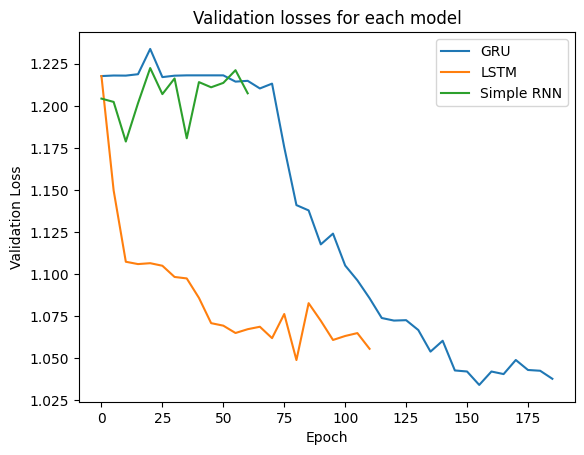

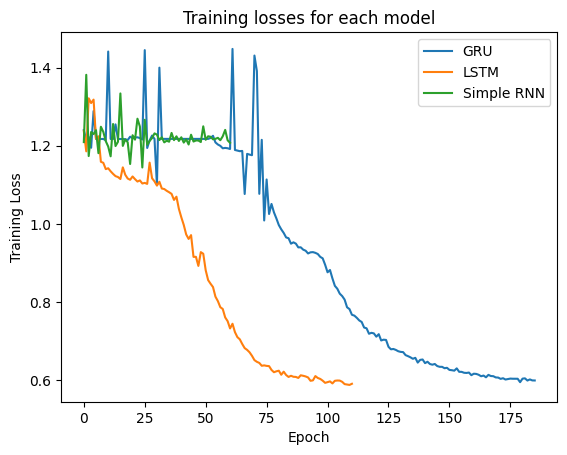

In [151]:
plt.plot(np.arange(len(train_l_gru), step=val_epoch), val_l_gru, label="GRU")
plt.plot(np.arange(len(train_l_lstm), step=val_epoch), val_l_lstm, label="LSTM")
plt.plot(np.arange(len(train_l_rnn), step=val_epoch), val_l_rnn, label="Simple RNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation losses for each model")
plt.show()


plt.plot(np.arange(len(train_l_gru)), train_l_gru, label="GRU")
plt.plot(np.arange(len(train_l_lstm)), train_l_lstm, label="LSTM")
plt.plot(np.arange(len(train_l_rnn)), train_l_rnn, label="Simple RNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training losses for each model")
plt.show()

Some things worth noticing: the simple RNN doesn't learn at all, and never gets past the "guessing" phase. It seems like the GRU losses are a lot more volatile than LSTM, which was apparent when training each model multiple times -- occasionally, GRU would never get past the guessing phase, similar to the simple RNN, and at other times, GRU would outperform LSTM. I think the disparity in performance from LSTM versus the basic RNN is mainly due to the forget gates implemented in the LSTM cell structure, as well as the issue with vanishing gradients. The ability for LSTMs to forget certain information means they get out of the "rut" of guessing very quickly, and the removal of vanishing gradients mean the weights get updated, while basic RNNs remain stagnant. I think the variability of GRUs compared to LSTMs is due to the removal of certain trainable parameters, which can make the loss more volatile. However, this also means that GRUs can converge more quickly than LSTMs in certain cases.

Although I guess time-series data could technically be converted to the usual features in a feed-forward network (such as simply adding a feature for position of the word in a sentence), I don't think this would capture semantic context as well as RNNs. For example, the word "like" generally has a positive connotation, but when preluded by a qualifier like "not" or "didn't" this now implies a strongly negative connotation. Simple feed-forward networks would not be able to pick up on this interaction between words, while RNNs are able to since each word impacts the next one.

### **Task 3: Word Embeddings**

For word embeddings, I chose to use FastText. The reason for this is it allows for easy lookup of OOV word embeddings by using subword embeddings to approximate whole word embeddings. However, the natural trade-off is decreased semantic representation.



In [147]:
!git clone https://github.com/facebookresearch/fastText.git
!sudo pip install ./fastText

fatal: destination path 'fastText' already exists and is not an empty directory.
Processing ./fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp311-cp311-linux_x86_64.whl size=4313386 sha256=af70ac3a9a736e79afac88ce540ccf884c85a0d14410964133c4bc525dceee05
  Stored in directory: /tmp/pip-ephem-wheel-cache-9m4xexkj/wheels/1e/bc/93/e4d717605b2816cf84bf6796e766c05fcc2fd4feb3f170fdf3
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [152]:
import fasttext
import fasttext.util
import numpy as np

ft = fasttext.load_model("/content/drive/MyDrive/Colab Notebooks/wiki.simple.bin")
fasttext.util.reduce_model(ft, 100) # Reduce model to 100 dimensions to reduce overhead -- my colab was occasionally running out of RAM without reducing dimensionality.


In [153]:
w1 = input("Input first word: ")
w2 = input("Input second word: ")

print(ft.get_word_vector(w1))
print(ft.get_word_vector(w2))

Input first word: cat
Input second word: dog
[ 0.23458758  0.3359176  -1.1792034   0.11905033  0.92409444  0.21441478
 -0.1436644   0.76755935  0.34944934 -0.17908329 -0.30552763  0.7788317
  0.4145707  -0.01853653  0.4402719  -0.41951588 -0.54648066  0.401248
 -0.1766725  -0.49539545  0.3135684   0.45503035  0.28758895  0.10372527
  0.38878134 -0.3718703  -0.10007501 -0.04760677  0.18724969 -0.33540905
 -0.3294418  -0.22748913 -0.44778624  0.19044898  0.2968199   0.542339
 -0.3920509  -0.613016   -0.45841172 -0.05204426  0.24037501  0.0716078
  0.3437278  -0.04447958 -0.17757179  0.34725845 -0.6002058  -0.06257948
 -0.20239507  0.172878    0.10016333  0.38468155  0.06434786 -0.1319954
  0.28960103  0.13897109 -0.04733545  0.3697808   0.02941013  0.24909395
  0.13931122 -0.12507334 -0.06251387  0.07041966 -0.09332858 -0.04684455
 -0.07353439  0.25386208  0.03998217  0.16980419 -0.5490905  -0.71570814
  0.43394566  0.2768747   0.08748184  0.04172411 -0.10783778 -0.3230693
  0.07127365 -

Cosine similarity is useful because it's a simple and easy way to compare word embeddings, and naturally falls within the range $[-1,1]$, making it easy to quickly determine how similar words are within the embedding space.

Input all words to be compared to each other, separated by a space: cat dog lion tiger jaguar wolf mother husband wife boyfriend closet love hate detest abhor time house museum truck table leave step
Cosine similarity between ['cat' 'cat'] : 1.0000
Cosine similarity between ['dog' 'cat'] : 0.7173
Cosine similarity between ['dog' 'dog'] : 1.0000
Cosine similarity between ['lion' 'cat'] : 0.5028
Cosine similarity between ['lion' 'dog'] : 0.4928
Cosine similarity between ['lion' 'lion'] : 1.0000
Cosine similarity between ['tiger' 'cat'] : 0.5314
Cosine similarity between ['tiger' 'dog'] : 0.5159
Cosine similarity between ['tiger' 'lion'] : 0.6309
Cosine similarity between ['tiger' 'tiger'] : 1.0000
Cosine similarity between ['jaguar' 'cat'] : 0.4496
Cosine similarity between ['jaguar' 'dog'] : 0.4612
Cosine similarity between ['jaguar' 'lion'] : 0.5804
Cosine similarity between ['jaguar' 'tiger'] : 0.6818
Cosine similarity between ['jaguar' 'jaguar'] : 1.0000
Cosine similarity between ['w

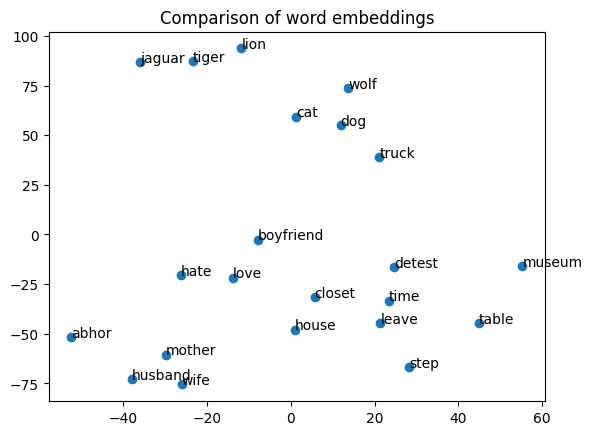

In [154]:
from sklearn.manifold import TSNE
from math import factorial

# Compute cosine similarity
def cosine_similarity(w1, w2):
  return np.sum((np.matmul(w1, w2.T)/(np.linalg.norm(w1, axis=1)*np.linalg.norm(w2, axis=1))*np.eye(np.shape(w1)[0])), axis=1)

i = input("Input all words to be compared to each other, separated by a space: ")
words = i.split(" ")
embeddings = [ft.get_word_vector(w) for w in words]
w1 = np.empty((sum(range(len(words)+1)),100))
w2 = np.empty((sum(range(len(words)+1)),100))
w3 = np.empty((sum(range(len(words)+1)),2), dtype = object)
for i in range(len(words)):
  for j in range(i+1):
    w1[sum(range(i+1))+j] = ft.get_word_vector(words[i])
    w2[sum(range(i+1))+j] = ft.get_word_vector(words[j])
    w3[sum(range(i+1))+j,0] = words[i]
    w3[sum(range(i+1))+j,1] = words[j]

cs = cosine_similarity(w1, w2)

for i in range(np.shape(w3)[0]):
  print("Cosine similarity between",w3[i,:],": {:.4f}".format(cs[i]))


x_embedded = TSNE(perplexity = 5).fit_transform(np.array(embeddings))

plt.scatter(x_embedded[:,0], x_embedded[:,1])
for i, txt in enumerate(words):
  plt.annotate(txt, (x_embedded[i,0],x_embedded[i,1]))
plt.title("Comparison of word embeddings")
plt.show()

From the above scatter plot, we can see how similar words like ["dog","cat"], ["lion","tiger","jaguar"] and ["mother","husband","wife"] cluster very close together, while words that don't have a correlation with each other, like ["time","truck"] and ["wolf","table"] are relatively far apart. We can also see how these clusters all contain points with similar angles w.r.t. zero, indicating a high cosine similarity.

One possible option for dissimilarity is normalized euclidean distance, which would be implemented as: $$\frac{\|w_1-w_2\|}{\|w_1\|+\|w_2\|}$$ This captures slightly more than just cosine similarity, since it also factors in the magnitudes of each embedding, while cosine similarity only factors in the angle. IF two embeddings with similar angles have very large differences in magnitude, cosine embedding will be inaccurate when computing dissimilarity, while Euclidean distance captures the accurate difference. The normalization of Euclidean distance restricts the range to [0,1] so that the scale between vectors is the same for better comparison.

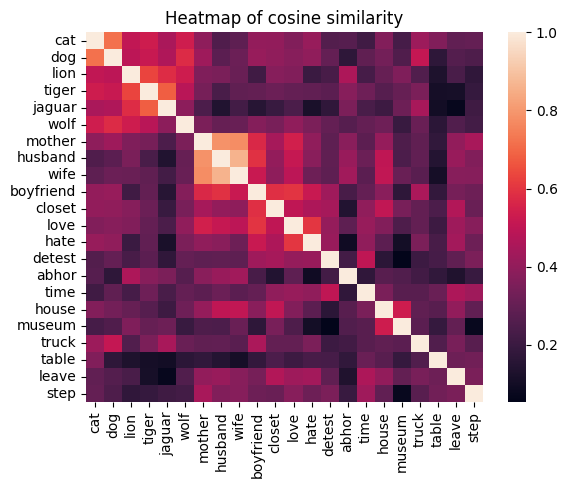

Highest cosine similarities between selected words:
cat: ['dog', 'wolf', 'tiger', 'lion']
dog: ['cat', 'wolf', 'tiger', 'truck']
lion: ['tiger', 'jaguar', 'wolf', 'cat']
tiger: ['jaguar', 'lion', 'cat', 'dog']
jaguar: ['tiger', 'lion', 'dog', 'cat']
wolf: ['dog', 'cat', 'lion', 'tiger']
mother: ['husband', 'wife', 'boyfriend', 'love']
husband: ['wife', 'mother', 'boyfriend', 'love']
wife: ['husband', 'mother', 'boyfriend', 'house']
boyfriend: ['love', 'husband', 'closet', 'mother']
closet: ['boyfriend', 'house', 'love', 'leave']
love: ['hate', 'boyfriend', 'mother', 'husband']
hate: ['love', 'boyfriend', 'closet', 'leave']
detest: ['time', 'closet', 'boyfriend', 'hate']
abhor: ['lion', 'wife', 'husband', 'mother']
time: ['detest', 'leave', 'step', 'love']
house: ['museum', 'closet', 'wife', 'husband']
museum: ['house', 'lion', 'closet', 'jaguar']
truck: ['dog', 'boyfriend', 'jaguar', 'cat']
table: ['cat', 'step', 'leave', 'time']
leave: ['closet', 'time', 'hate', 'love']
step: ['mother

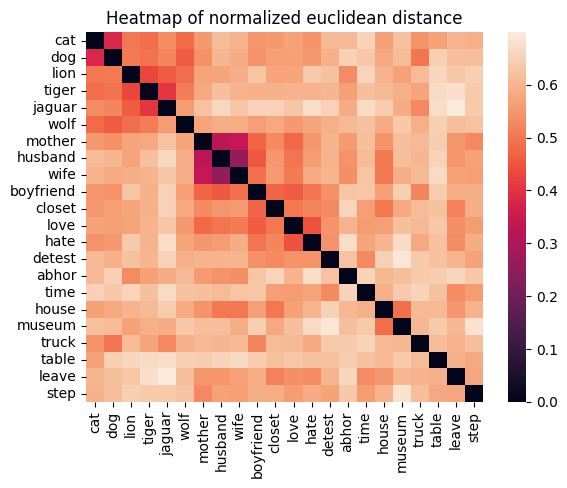

Highest euclidean distances between selected words:
cat: ['museum', 'husband', 'detest', 'abhor']
dog: ['table', 'time', 'leave', 'step']
lion: ['time', 'step', 'hate', 'leave']
tiger: ['table', 'step', 'husband', 'time']
jaguar: ['table', 'hate', 'time', 'husband']
wolf: ['museum', 'step', 'time', 'leave']
mother: ['jaguar', 'time', 'museum', 'truck']
husband: ['table', 'tiger', 'museum', 'cat']
wife: ['jaguar', 'time', 'truck', 'detest']
boyfriend: ['museum', 'table', 'time', 'lion']
closet: ['jaguar', 'table', 'truck', 'tiger']
love: ['jaguar', 'museum', 'truck', 'abhor']
hate: ['jaguar', 'museum', 'lion', 'table']
detest: ['jaguar', 'house', 'truck', 'abhor']
abhor: ['leave', 'closet', 'time', 'dog']
time: ['lion', 'truck', 'abhor', 'cat']
house: ['jaguar', 'tiger', 'table', 'truck']
museum: ['step', 'hate', 'boyfriend', 'time']
truck: ['detest', 'abhor', 'step', 'table']
table: ['wife', 'tiger', 'lion', 'husband']
leave: ['tiger', 'abhor', 'lion', 'dog']
step: ['lion', 'tiger', 'j

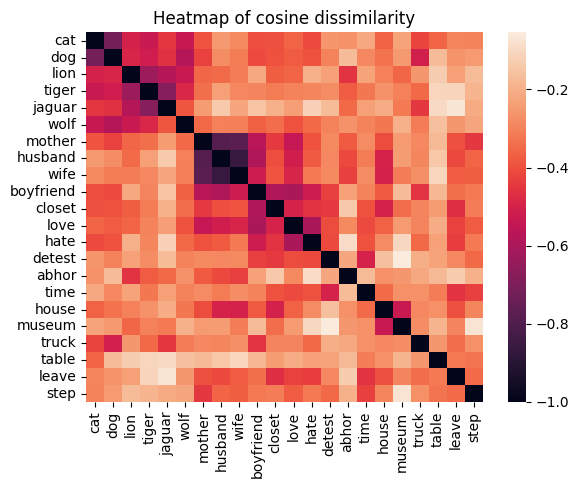

Highest cosine dissimilarities between selected words:
cat: ['museum', 'husband', 'detest', 'abhor']
dog: ['abhor', 'step', 'museum', 'leave']
lion: ['step', 'hate', 'boyfriend', 'time']
tiger: ['leave', 'step', 'husband', 'house']
jaguar: ['table', 'hate', 'husband', 'boyfriend']
wolf: ['museum', 'step', 'leave', 'abhor']
mother: ['jaguar', 'museum', 'time', 'detest']
husband: ['table', 'tiger', 'museum', 'cat']
wife: ['jaguar', 'truck', 'time', 'cat']
boyfriend: ['museum', 'table', 'lion', 'abhor']
closet: ['jaguar', 'table', 'truck', 'step']
love: ['jaguar', 'museum', 'abhor', 'truck']
hate: ['museum', 'jaguar', 'lion', 'table']
detest: ['house', 'jaguar', 'truck', 'abhor']
abhor: ['leave', 'closet', 'dog', 'time']
time: ['cat', 'lion', 'jaguar', 'truck']
house: ['jaguar', 'tiger', 'abhor', 'table']
museum: ['step', 'hate', 'boyfriend', 'table']
truck: ['abhor', 'table', 'lion', 'step']
table: ['wife', 'tiger', 'lion', 'husband']
leave: ['tiger', 'abhor', 'lion', 'wolf']
step: ['lio

In [155]:
import seaborn as sns

def euclidean_dissimilarity(w1, w2):
  return (np.linalg.norm(w1-w2, axis=1))/(np.linalg.norm(w1, axis=1)+np.linalg.norm(w2, axis=1))

def cosine_dissimilarity(w1, w2):
  return -1*cosine_similarity(w1, w2)


def word_compare(w1, w2, comparison):
  if comparison == "euc":
    return euclidean_dissimilarity(w1, w2)
  elif comparison == "cos":
    return cosine_similarity(w1, w2)
  elif comparison == "cos dis":
    return cosine_dissimilarity(w1, w2)
  else:
    print("Could not parse comparison method")

cs = word_compare(w1, w2, "cos")
ed = word_compare(w1, w2, "euc")
cd = word_compare(w1, w2, "cos dis")


df = pd.DataFrame(columns = words, index = words, dtype=float)

for i in range(np.shape(w3)[0]):
  df.loc[w3[i,0],w3[i,1]] = cs[i]
  df.loc[w3[i,1],w3[i,0]] = cs[i]
sns.heatmap(df)
plt.title("Heatmap of cosine similarity")
plt.show()
print("Highest cosine similarities between selected words:")
for i in range(len(words)):
  s = df.sort_values(by=words[i], ascending=False)
  print("{}:".format(words[i]),list(s[words[i]].index[1:5]))
print('\n')


for i in range(np.shape(w3)[0]):
  df.loc[w3[i,0],w3[i,1]] = ed[i]
  df.loc[w3[i,1],w3[i,0]] = ed[i]
sns.heatmap(df)
plt.title("Heatmap of normalized euclidean distance")
plt.show()
print("Highest euclidean distances between selected words:")
for i in range(len(words)):
  s = df.sort_values(by=words[i], ascending=False)
  print("{}:".format(words[i]),list(s[words[i]].index[1:5]))
print('\n')


for i in range(np.shape(w3)[0]):
  df.loc[w3[i,0],w3[i,1]] = cd[i]
  df.loc[w3[i,1],w3[i,0]] = cd[i]
sns.heatmap(df)
plt.title("Heatmap of cosine dissimilarity")
plt.show()
print("Highest cosine dissimilarities between selected words:")
for i in range(len(words)):
  s = df.sort_values(by=words[i], ascending=False)
  print("{}:".format(words[i]),list(s[words[i]].index[1:5]))

